<a href="https://colab.research.google.com/github/howcanigetyourmind/deeplearning-koreauniversty/blob/master/02_2012_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input Data Preparation

In [0]:
 #!unzip asirra_smaller.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd "/content/drive/My Drive/1907_이미지 영상 인식 및 분석 (남중구 대표)/_src/NNA"
#!cp -r asirra /content
!cp -r asirra_smaller /content

[Errno 2] No such file or directory: '/content/drive/My Drive/1907_이미지 영상 인식 및 분석 (남중구 대표)/_src/NNA'
/content
cp: cannot stat 'asirra_smaller': No such file or directory


In [0]:
%cd /content
!ls

/content
asirra_smaller	drive  neural-style  sample_data


In [0]:
import tensorflow as tf
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tensorflow.contrib.learn.python.learn.datasets import base

#### dataset for train

원본 이미지를 읽어와서 먼저 256 x 256으로 확대  
그 다음 random_crop_reflect() 로 이미지 augment 해서 227 x 227 이미지 반환  
(본 논문은 224 x 224 사이즈 사용했으나, Practical 하게는 227 이 잘 되서 대부분 227 x 227 사용)

#### dataset for validation & test

corner_center_crop_reflect() 로 이미지 augment 해서  
한 이미지 당 10 개의 변환된 이미지 만들어냄
(-> validation, test 할 때는 추가로 10 개 생성된 데이터에 대한 forward propagation 고려해야)

In [0]:
class DataSet(object):
    def __init__(self, data_type, images, labels=None):
        """
        Construct a new DataSet object.
        :param images: np.ndarray, shape: (N, H, W, C).
        :param labels: np.ndarray, shape: (N, num_classes) or (N,).
        """
        if labels is not None:
            assert images.shape[0] == labels.shape[0], (
                'Number of examples mismatch, between images and labels.'
            )
        self._num_examples = images.shape[0]
        self._data_type = data_type
        self._images = images
        self._labels = labels    # NOTE: this can be None, if not given.
        self._indices = np.arange(self._num_examples, dtype=np.uint)    # image/label indices(can be permuted)
        self._reset()

    def _reset(self):
        """Reset some variables."""
        self._completed_epoch_count = 0
        self._idx_in_current_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    def next_batch(self, batch_size, shuffle=True, augment=True, fake_data=False):
        """
        Return the next `batch_size` examples from this dataset.
        :param batch_size: int, size of a single batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :param augment: bool, whether to perform data augmentation while sampling a batch.
        :param is_train: bool, current phase for sampling.
        :param fake_data: bool, whether to generate fake data (for debugging).
        :return: batch_images: np.ndarray, shape: (N, h, w, C) or (N, 10, h, w, C).
                 batch_labels: np.ndarray, shape: (N, num_classes) or (N,).
        """
        if fake_data:
            fake_batch_images = np.random.random(size=(batch_size, 227, 227, 3))
            fake_batch_labels = np.zeros((batch_size, 2), dtype=np.uint8)
            fake_batch_labels[np.arange(batch_size), np.random.randint(2, size=batch_size)] = 1
            return fake_batch_images, fake_batch_labels

        idx_begin = self._idx_in_current_epoch

        # Shuffle the dataset, for the first epoch
        if self._completed_epoch_count == 0 and idx_begin == 0 and shuffle:
            np.random.shuffle(self._indices)

        # Go to the next epoch, if current index goes beyond the total number of examples
        if idx_begin + batch_size > self._num_examples:
            # Increment the number of epochs completed
            self._completed_epoch_count += 1
            
            # Get the rest examples in this epoch
            remaining_num_examples = self._num_examples - idx_begin
            remaining_indices = self._indices[idx_begin:self._num_examples]

            # Shuffle the dataset, after finishing a single epoch
            if shuffle:
                np.random.shuffle(self._indices)

            # Start the next epoch
            idx_begin = 0
            self._idx_in_current_epoch = batch_size - remaining_num_examples
            idx_end = self._idx_in_current_epoch
            new_indices = self._indices[idx_begin:idx_end]

            remaining_images = self.images[remaining_indices]
            new_images = self.images[new_indices]
            batch_images = np.concatenate((remaining_images, new_images), axis=0)
            if self.labels is not None:
                remaining_labels = self.labels[remaining_indices]
                new_labels = self.labels[new_indices]
                batch_labels = np.concatenate((remaining_labels, new_labels), axis=0)
            else:
                batch_labels = None
        else:
            self._idx_in_current_epoch += batch_size
            idx_end = self._idx_in_current_epoch
            indices = self._indices[idx_begin:idx_end]
            batch_images = self.images[indices]
            if self.labels is not None:
                batch_labels = self.labels[indices]
            else:
                batch_labels = None

        if augment and self._data_type == 'train':
            # Perform data augmentation, for training phase
            batch_images = random_crop_reflect(batch_images, 227)
        elif augment and self._data_type != 'train':
            # Perform data augmentation, for evaluation phase(10x)
            batch_images = corner_center_crop_reflect(batch_images, 227)
        else:
            # Don't perform data augmentation, generating center-cropped patches
            batch_images = center_crop(batch_images, 227)
        
        return batch_images, batch_labels

In [0]:
def random_crop_reflect(images, crop_l):
    """
    Perform random cropping and reflection from images.
    :param images: np.ndarray, shape: (N, H, W, C).
    :param crop_l: int, a side length of crop region.
    :return: np.ndarray, shape: (N, h, w, C).
    """
    H, W = images.shape[1:3]
    augmented_images = []
    for image in images:    # image.shape: (H, W, C)
            
        # Randomly crop patch
        y = np.random.randint(H-crop_l)
        x = np.random.randint(W-crop_l)
        image = image[y:y+crop_l, x:x+crop_l]    # (h, w, C)

        # Randomly reflect patch horizontally
        reflect = bool(np.random.randint(2))
        if reflect:
            image = image[:, ::-1]

        augmented_images.append(image)
    return np.stack(augmented_images)    # shape: (N, h, w, C)


def corner_center_crop_reflect(images, crop_l):
    """
    Perform 4 corners and center cropping and reflection from images,
    resulting in 10x augmented patches.
    :param images: np.ndarray, shape: (N, H, W, C).
    :param crop_l: int, a side length of crop region.
    :return: np.ndarray, shape: (N, 10, h, w, C).
    """
    H, W = images.shape[1:3]
    augmented_images = []
    for image in images:    # image.shape: (H, W, C)
        aug_image_orig = []
        # Crop image in 4 corners
        aug_image_orig.append(image[:crop_l, :crop_l])
        aug_image_orig.append(image[:crop_l, -crop_l:])
        aug_image_orig.append(image[-crop_l:, :crop_l])
        aug_image_orig.append(image[-crop_l:, -crop_l:])
        # Crop image in the center
        aug_image_orig.append(image[H//2-(crop_l//2):H//2+(crop_l-crop_l//2),
                                    W//2-(crop_l//2):W//2+(crop_l-crop_l//2)])
        aug_image_orig = np.stack(aug_image_orig)    # (5, h, w, C)

        # Flip augmented images and add it
        aug_image_flipped = aug_image_orig[:, :, ::-1]    # (5, h, w, C)
        aug_image = np.concatenate((aug_image_orig, aug_image_flipped), axis=0)    # (10, h, w, C)
        augmented_images.append(aug_image)
    return np.stack(augmented_images)    # shape: (N, 10, h, w, C)


def center_crop(images, crop_l):
    """
    Perform center cropping of images.
    :param images: np.ndarray, shape: (N, H, W, C).
    :param crop_l: int, a side length of crop region.
    :return: np.ndarray, shape: (N, h, w, C).
    """
    H, W = images.shape[1:3]
    cropped_images = []
    for image in images:    # image.shape: (H, W, C)
        # Crop image in the center
        cropped_images.append(image[H//2-(crop_l//2):H//2+(crop_l-crop_l//2),
                              W//2-(crop_l//2):W//2+(crop_l-crop_l//2)])
    return np.stack(cropped_images)

In [0]:
def read_asirra_subset(subset_dir, one_hot=True, sample_size=None):
    # Read trainval data
    filename_list = os.listdir(subset_dir)
    set_size = len(filename_list)

    if sample_size is not None and sample_size < set_size:
        # Randomly sample subset of data when sample_size is specified
        filename_list = np.random.choice(filename_list, size=sample_size, replace=False)
        set_size = sample_size
    else:
        # Just shuffle the filename list
        np.random.shuffle(filename_list)

    # Pre-allocate data arrays
    msg_interval = 1000 if set_size >= 1000 else 10
    
    X_set = np.empty((set_size, 256, 256, 3), dtype=np.float32)    # (N, H, W, 3)
    y_set = np.empty((set_size), dtype=np.uint8)                   # (N,)
    for i, filename in enumerate(filename_list):
        if i % msg_interval == 0:
            print('    progress: {}/{}...'.format(i, set_size), end='\r')
        label = filename.split('.')[0]
        if label == 'cat':
            y = 0
        else:  # label == 'dog'
            y = 1
        file_path = os.path.join(subset_dir, filename)
        img = imread(file_path)    # shape: (H, W, 3), range: [0, 255]
        img = resize(img, (256, 256), mode='constant').astype(np.float32)    # (256, 256, 3), [0.0, 1.0]
        X_set[i] = img
        y_set[i] = y

    if one_hot:
        # Convert labels to one-hot vectors, shape: (N, num_classes)
        y_set_oh = np.zeros((set_size, 2), dtype=np.uint8)
        y_set_oh[np.arange(set_size), y_set] = 1
        y_set = y_set_oh
        
    print('    progress: {}/{}...'.format(set_size, set_size), end='\r')
    print('\nDone')

    return X_set, y_set, set_size

In [0]:
def read_data_sets(subset_dir, one_hot=True, sample_train_size=None):
    print("Reading train/validation data")
    train_images, train_labels, set_size = read_asirra_subset(subset_dir + 'train', one_hot, sample_train_size) 
    validation_size = int(set_size * 0.2)
    
    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    print("\nReading test data..")
    test_images, test_labels, _ = read_asirra_subset(subset_dir + 'test', one_hot) 

    train = DataSet('train', train_images, train_labels)
    validation = DataSet('validation', validation_images, validation_labels)
    test = DataSet('test', test_images, test_labels)    
    
    return base.Datasets(train=train, validation=validation, test=test)

In [0]:
asirra = read_data_sets("./asirra_smaller/", one_hot=True)   
#asirra = read_data_sets("./asirra/", one_hot=True)   

Reading train/validation data
    progress: 16/16...
Done

Reading test data..
    progress: 10/10...
Done


In [0]:
X_train = asirra.train.images
Y_train = asirra.train.labels
X_validation = asirra.validation.images
Y_validation = asirra.validation.labels
X_test = asirra.test.images
Y_test = asirra.test.labels

print("Training Set  : {0} samples".format(asirra.train.num_examples))
print("Validation Set: {0} samples".format(asirra.validation.num_examples))
print("Test Set      : {0} samples".format(asirra.test.num_examples))

Training Set  : 13 samples
Validation Set: 3 samples
Test Set      : 10 samples


In [0]:
print("Image Shape   : {0}".format(X_train[0].shape))

NameError: ignored

In [0]:
batch_length = 2
train_batch_loop_count = int(asirra.train.num_examples / batch_length)
validation_batch_loop_count = int(asirra.validation.num_examples / batch_length)
test_batch_loop_count = int(asirra.test.num_examples / batch_length)

print("Training   batch loop count  : {0}".format(train_batch_loop_count))
print("Validation batch loop count  : {0}".format(validation_batch_loop_count))
print("Test       batch loop count  : {0}".format(test_batch_loop_count))

Training   batch loop count  : 6
Validation batch loop count  : 1
Test       batch loop count  : 5


#### Preview an input data

256 x 256 이미지로 일정하게 만들어서 읽어옴

Loaded data shape: (256, 256, 3)


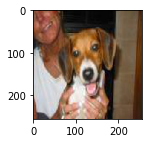

In [0]:
import matplotlib.pyplot as plt

sample_idx = 5 #여기 숫자 바꾸면 개,고양이 바뀌어서 나옴.

print("Loaded data shape: {0}".format(asirra.train.images[0].shape))
plt.figure(figsize=(2,2))
plt.imshow(
     asirra.train.images[sample_idx],
     cmap='Greys',
     interpolation='nearest')
plt.show()


#### Preview an augmented data for AlexNet Input

256 x 256 이미지에서 227 x 227 이미지들을 잘라냄

Resized data during reading batch: 227 x 227 x 3 ->  AlexNet input size


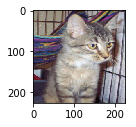

In [0]:
print("Resized data during reading batch: 227 x 227 x 3 ->  AlexNet input size")
batch_x, batch_y = asirra.train.next_batch(1)

images = batch_x
fig, axes = plt.subplots(1, 1, figsize=(1.7, 1.7), squeeze=True)

axes.imshow(
    images[0],
    cmap='Greys', interpolation='nearest')

plt.show()

#### Training stage

train 데이터 13개이고 batch 크기가 2 이면  
총 6번 loop 돌면서 매 번 2개의 이미지에 대한 train 한다  
이때 생성되는 이미지 테스트로 출력해보기

step 1   batch_y len 2


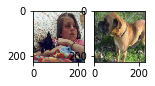

step 2   batch_y len 2


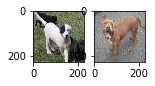

step 3   batch_y len 2


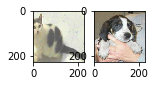

step 4   batch_y len 2


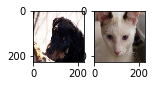

step 5   batch_y len 2


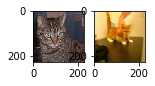

step 6   batch_y len 2


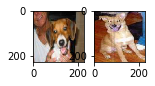

In [0]:
import matplotlib.pyplot as plt
for step in range(train_batch_loop_count):
    batch_x, batch_y = asirra.train.next_batch(batch_length)
    print('step', step + 1, '  batch_y len', len(batch_y))
    
    images = batch_x
    fig, axes = plt.subplots(1, 2, figsize=(2,3), squeeze=True)

    k = 0
    for i in range(2):
        axes[i].imshow(
             images[k],
             cmap='Greys', interpolation='nearest')
        k += 1

    plt.show()

#### Test stage

test 데이터 10개이고 batch 크기 2 이면 총 5번의 loop 필요  
validation 과 test 시에는 한 이미지 당 10개의 augment 된 이미지를 출력하기 때문에  
총 5번 loop 돌면서 매 번 2 x 10 = 20 개의 이미지에 대한 train 한다  

이 부분 고려해서 batch loop 설계해야 함

이때 생성되는 이미지 테스트로 출력해보기

step 1   batch_y len 2


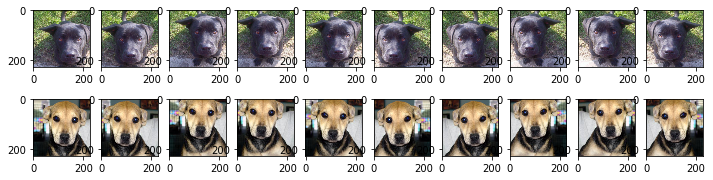

step 2   batch_y len 2


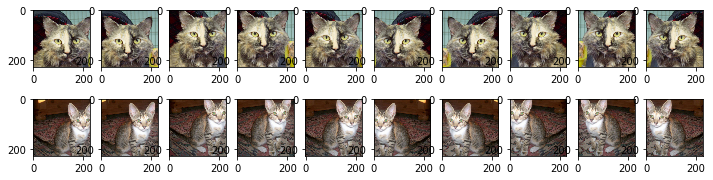

step 3   batch_y len 2


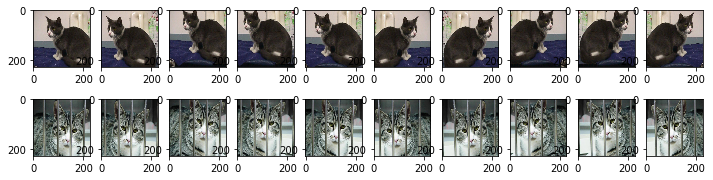

step 4   batch_y len 2


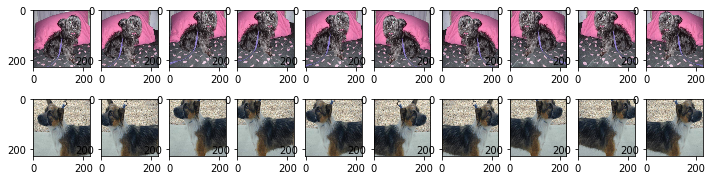

step 5   batch_y len 2


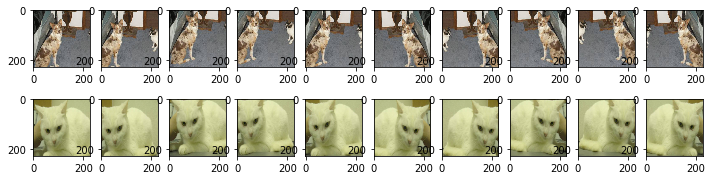

In [0]:
import matplotlib.pyplot as plt
for step in range(test_batch_loop_count):
    batch_x, batch_y = asirra.test.next_batch(batch_length)
    print('step', step + 1, '  batch_y len', len(batch_y))
    
    images = batch_x
    fig, axes = plt.subplots(2, 10, figsize=(12,3), squeeze=True)
    
    for i in range(2):
        for j in range(10):
            axes[i, j].imshow(
                 images[i][j],
                 cmap='Greys', interpolation='nearest')

    plt.show()

<br />
# Hyperparameters

In [0]:
# hyperparameters
learning_rate = 0.01
mu            = 0     # mean
sigma         = 0.01   # std. dev.

epoch_size    = 5       # tr data 10번 반복해서 학습
batch_length  = 100       # 1 epoch (tr data 한번 학습) 시 100개씩 배치로 읽어


train_batch_loop_count = int(asirra.train.num_examples / batch_length)
validation_batch_loop_count = int(asirra.validation.num_examples / batch_length)
test_batch_loop_count = int(asirra.test.num_examples / batch_length)

if asirra.train.num_examples < batch_length:
    train_batch_loop_count = asirra.train.num_examples
if asirra.validation.num_examples < batch_length:
    validation_batch_loop_count = asirra.validation.num_examples
if asirra.test.num_examples < batch_length:
    test_batch_loop_count = asirra.test.num_examples
    
train_dropout_rate      = 0.5 #      train dropout (keep_prob) rate
validation_dropout_rate = 1.0 # validation dropout (keep_prob) rate
test_dropout_rate       = 1.0 #       test dropout (keep_prob) rate

input_width   = 227    # resized asirra data image 227 x 227
input_height  = 227    # resized asirra data image 227 x 227
input_channel = 3      # RGB Color
output_size   = 2      # 0 ~ 1 까지 2개 클래스를 one-hot encoding 값으로 사용할 것

asirra.train.num_examples
if asirra.train.num_examples < batch_length:
    train_batch_size = asirra.train.num_examples

<br />
# Build AlexNet Model

In [0]:
tf.reset_default_graph() # reset tensor graph
tf.set_random_seed(777)  # for reproducibility

In [0]:
with tf.name_scope('input') as scope:
    X = tf.placeholder(tf.float32, [None, input_width, input_height, input_channel], name='x_input')
    Y = tf.placeholder(tf.float32, [None, output_size], name='y_input')

In [0]:
with tf.name_scope('dropout') as scope:
    # dropout (keep_prob) rate: 0.7 for training, and  1.0 for testing
    keep_prob_value = tf.placeholder(tf.float32)

In [0]:
# Input = 227x227x3. Output = 55x55x96
with tf.name_scope('conv_layer1') as scope:
    filter_size    = 11
    input_channel  = 3
    output_channel = 96
    stride         = 4
    bias_value     = 0.1
    # filter size 11 x 11
    # input channel 3, output channel 96
    # conv1_kernel = tf.Variable(tf.truncated_normal(
    #    shape=[filter_size, filter_size, input_channel, output_channel], mean=mu, stddev=sigma))
    conv1_kernel = tf.get_variable('conv1_kernel', [filter_size, filter_size, input_channel, output_channel], tf.float32,
                              tf.random_normal_initializer(mean=mu, stddev=sigma))
    #conv1_bias = tf.Variable(tf.random_normal([96]))
    conv1_bias = tf.get_variable('conv1_bias', [output_channel], tf.float32,
                             tf.constant_initializer(value=bias_value))
    conv1 = tf.nn.conv2d(X, conv1_kernel, strides=[1,stride,stride,1], padding='VALID') + conv1_bias    
    conv1 = tf.nn.relu(conv1)  # activation (non-linearizing)
    
    conv1_k_hist = tf.summary.histogram('kernel_conv1', conv1_kernel)
    conv1_b_hist = tf.summary.histogram('bias_conv1', conv1_bias)
    conv1_hist = tf.summary.histogram('conv1_layer', conv1)

In [0]:
# Input = 55x55x96. Output = 27x27x96
with tf.name_scope('pooling_layer1') as scope:
    # overlapping pooling: pooling kernel size 3 x 3, stride 2
    filter_size    = 3
    stride         = 2
    pool1 = tf.nn.max_pool(conv1, 
                           ksize = [1,filter_size,filter_size,1],
                           strides = [1,stride,stride,1], padding = 'VALID')
    
    pool1_hist = tf.summary.histogram('pool1_layer', pool1)

In [0]:
# Input = 27x27x96. Output = 27x27x256
with tf.name_scope('conv_layer2') as scope:
    # filter size 5 x 5
    # input channel 96, output channel 256
    filter_size    = 5
    input_channel  = 96
    output_channel = 256
    stride         = 1
    conv2_kernel = tf.Variable(tf.truncated_normal(
        shape=[filter_size, filter_size, input_channel, output_channel], mean=mu, stddev=sigma))
    #conv2_bias = tf.Variable(tf.random_normal([output_channel]))
    conv2_bias = tf.get_variable('conv2_bias', [output_channel], tf.float32,
                             tf.constant_initializer(value=bias_value))
    conv2 = tf.nn.conv2d(pool1, conv2_kernel, strides=[1,stride,stride,1], padding='SAME') + conv2_bias     
    conv2 = tf.nn.relu(conv2)  # activation
    
    conv2_k_hist = tf.summary.histogram('kernel_conv2', conv2_kernel)
    conv2_b_hist = tf.summary.histogram('bias_conv2', conv2_bias)
    conv2_hist = tf.summary.histogram('conv2_layer', conv2)

In [0]:
# Input = 27x27x256. Output = 13x13x256.
with tf.name_scope('pooling_layer2') as scope:
    # overlapping pooling: pooling kernel size 3 x 3, stride 2
    filter_size    = 3
    stride         = 2
    pool2 = tf.nn.max_pool(conv2, 
                           ksize = [1,filter_size,filter_size,1], 
                           strides = [1,stride,stride,1], padding = 'VALID') 
    
    pool2_hist = tf.summary.histogram('pool2_layer', pool2)

In [0]:
# Input = 13x13x256. Output = 13x13x384
with tf.name_scope('conv_layer3') as scope:
    # filter size 3 x 3
    # input channel 256, output channel 384
    filter_size    = 3
    input_channel  = 256
    output_channel = 384
    stride         = 1
    conv3_kernel = tf.Variable(tf.truncated_normal(
        shape=[filter_size, filter_size, input_channel, output_channel], mean=mu, stddev=sigma))
    #conv3_bias = tf.Variable(tf.random_normal([output_channel]))
    conv3_bias = tf.get_variable('conv3_bias', [output_channel], tf.float32,
                             tf.constant_initializer(value=bias_value))
    conv3 = tf.nn.conv2d(pool2, conv3_kernel, strides=[1,stride,stride,1], padding='SAME') + conv3_bias
    conv3 = tf.nn.relu(conv3)  # activation
    
    conv3_k_hist = tf.summary.histogram('kernel_conv3', conv3_kernel)
    conv3_b_hist = tf.summary.histogram('bias_conv3', conv3_bias)
    conv3_hist = tf.summary.histogram('conv3_layer', conv3)

In [0]:
# Input = 13x13x384. Output = 13x13x384
with tf.name_scope('conv_layer4') as scope:
    # filter size 3 x 3
    # input channel 384, output channel 384
    filter_size    = 3
    input_channel  = 384
    output_channel = 384
    stride         = 1
    conv4_kernel = tf.Variable(tf.truncated_normal(
        shape=[filter_size, filter_size, input_channel, output_channel], mean=mu, stddev=sigma))
    #conv4_bias = tf.Variable(tf.random_normal([output_channel]))
    conv4_bias = tf.get_variable('conv4_bias', [output_channel], tf.float32,
                             tf.constant_initializer(value=bias_value))
    conv4 = tf.nn.conv2d(conv3, conv4_kernel, strides=[1,stride,stride,1], padding='SAME') + conv4_bias
    conv4 = tf.nn.relu(conv4)  # activation
    
    conv4_k_hist = tf.summary.histogram('kernel_conv4', conv4_kernel)
    conv4_b_hist = tf.summary.histogram('bias_conv4', conv4_bias)
    conv4_hist = tf.summary.histogram('conv4_layer', conv4)

In [0]:
# Input = 13x13x384. Output = 13x13x256
with tf.name_scope('conv_layer5') as scope:
    # filter size 3 x 3
    # input channel 384, output channel 256
    filter_size    = 3
    input_channel  = 384
    output_channel = 256
    stride         = 1
    conv5_kernel = tf.Variable(tf.truncated_normal(
        shape=[filter_size, filter_size, input_channel, output_channel], mean=mu, stddev=sigma))
    #conv5_bias = tf.Variable(tf.random_normal([output_channel]))
    conv5_bias = tf.get_variable('conv5_bias', [output_channel], tf.float32,
                             tf.constant_initializer(value=bias_value))
    conv5 = tf.nn.conv2d(conv4, conv5_kernel, strides=[1,stride,stride,1], padding='SAME') + conv5_bias
    conv5 = tf.nn.relu(conv5)  # activation
    
    conv5_k_hist = tf.summary.histogram('kernel_conv5', conv5_kernel)
    conv5_b_hist = tf.summary.histogram('bias_conv5', conv5_bias)
    conv5_hist = tf.summary.histogram('conv5_layer', conv5)

In [0]:
# Input = 13x13x256. Output = 6x6x256.
with tf.name_scope('pooling_layer5') as scope:
    # overlapping pooling: pooling kernel size 3 x 3, stride 2
    filter_size    = 3
    stride         = 2
    pool5 = tf.nn.max_pool(conv5, 
                           ksize = [1,filter_size,filter_size,1], 
                           strides = [1,stride,stride,1], padding = 'VALID') 
    
    pool5_hist = tf.summary.histogram('pool5_layer', pool5)

In [0]:
# Input = 6x6x256. Output = 9216x1.
with tf.name_scope('flatten_layer') as scope:
    flattened = tf.contrib.layers.flatten(pool5)
    
    flatten_hist = tf.summary.histogram('flatten_layer', flattened)

W0724 13:50:01.619810 140713433716608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


In [0]:
# Input = 9216x1. Output = 4096x1.
with tf.name_scope('fc_layer1') as scope:
    input_size = 9216
    output_size = 4096
    fc1_weight = tf.Variable(tf.truncated_normal(shape=[input_size, output_size], mean=mu, stddev=sigma))
    fc1_bias = tf.Variable(tf.random_normal([output_size]))
    fc1 = tf.matmul(flattened, fc1_weight) + fc1_bias
    fc1 = tf.nn.relu(fc1)  # activation
    fc1= tf.nn.dropout(fc1, keep_prob=keep_prob_value)
    
    fc1_w_hist = tf.summary.histogram('weight_fc1', fc1_weight)
    fc1_b_hist = tf.summary.histogram('bias_fc1', fc1_bias)
    fc1_hist = tf.summary.histogram('fc1_layer', fc1)

W0724 13:50:01.925822 140713433716608 deprecation.py:506] From <ipython-input-28-00798bdb1a20>:8: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Input = 4096x1. Output = 4096x1.
with tf.name_scope('fc_layer2') as scope:
    input_size = 4096
    output_size = 4096
    fc2_weight = tf.Variable(tf.truncated_normal(shape=[input_size, output_size], mean=mu, stddev=sigma))
    fc2_bias = tf.Variable(tf.random_normal([output_size]))
    fc2 = tf.matmul(fc1, fc2_weight) + fc2_bias
    fc2 = tf.nn.relu(fc2)  # activation
    fc2= tf.nn.dropout(fc2, keep_prob=keep_prob_value)
    
    fc2_w_hist = tf.summary.histogram('weight_fc2', fc2_weight)
    fc2_b_hist = tf.summary.histogram('bias_fc2', fc2_bias)
    fc2_hist = tf.summary.histogram('fc2_layer', fc2)

In [0]:
# Input = 4096x1. Output = 2x1.
with tf.name_scope('fc_layer3') as scope:
    input_size = 4096
    output_size = 2
    fc3_weight = tf.Variable(tf.truncated_normal(shape=[input_size, output_size], mean=mu, stddev=sigma))
    fc3_bias = tf.Variable(tf.random_normal([output_size]))
    logits = tf.matmul(fc2, fc3_weight) + fc3_bias
    h = tf.nn.softmax(logits)  # Hypothesis (using softmax)
    
    fc3_w_hist = tf.summary.histogram('weight_fc3', fc3_weight)
    fc3_b_hist = tf.summary.histogram('bias_fc3', fc3_bias)
    hypothesis_hist = tf.summary.histogram('hypothesis', h)

In [0]:
with tf.name_scope("cost") as scope:
    # cost function: cross entropy cost/loss
    # cost function    L = 1/N * Σ D(S(WXi + b), Li)    cost function L은 loss 의미 
    # cross entropy    D(S, L) = - Σ Li log(Si)         D(S, Li)의 L은 label 의미
    # cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(h), axis = 1))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
    cost = tf.reduce_mean(cross_entropy)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    
    cost_summ = tf.summary.scalar('cost', cost)

In [0]:
with tf.name_scope('accuracy') as scope:
    
    with tf.name_scope('correct_prediction') as scope:
        correct_prediction = tf.equal(tf.argmax(h, 1), tf.argmax(Y, 1))
    with tf.name_scope('correct') as scope:
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    accuracy_summ = tf.summary.scalar("accuracy", accuracy, ['merged_accuracy'])

<br />
# Run Train & Test

#### functions to help batch training/testing

In [0]:
def process_train(data, merged_summary, writer, epoch): 
    
    sum_cost = 0
    batch_size = train_batch_loop_count
    for step in range(batch_size):
        batch_x, batch_y = data.next_batch(batch_length)   
                
        summary, cost_res, _ = sess.run([merged_summary, cost, train],
                                      feed_dict = {X: batch_x,
                                                   Y: batch_y,
                           keep_prob_value: train_dropout_rate})
        
        #writer.add_summary(summary, epoch * batch_size + step)
        sum_cost += cost_res

    return sum_cost / batch_size

def process_validation(data, merged_validation_accuracy, writer, epoch):
    sum_accuracy = 0
    batch_size = validation_batch_loop_count
    for step in range(batch_size):
        batch_x, batch_y = data.next_batch(batch_length)
        
        # augmented batch_x.shape: (N, 10, h, w, C)
        # reshape: batch_x[:,] (N, h, w, C)
        for i in range(10):
            _accuracy = sess.run([accuracy], 
                                 feed_dict = {X: batch_x[:,i],  # (N, h, w, C)
                                              Y: batch_y,
                           keep_prob_value: validation_dropout_rate})

            sum_accuracy += _accuracy[0] * batch_length
            # print('_accuracy x batch_length', _accuracy[0] * batch_length)

            #merged = sess.run([merged_validation_accuracy],
            #        feed_dict = {X: batch_x[:,i], Y: batch_y,
            #               keep_prob_value: validation_dropout_rate})

        #writer.add_summary(merged[0], epoch * batch_size + step)

    return sum_accuracy / (batch_size * 10) # batch_size # (batch_size * 10)

def process_test(data):   
    sum_accuracy = 0
    batch_size = test_batch_loop_count
    for step in range(batch_size):
        batch_x, batch_y = data.next_batch(batch_length)  
        
        for i in range(10):
            _accuracy = sess.run([accuracy], 
                                 feed_dict = {X: batch_x[:,i],  # (N, h, w, C)
                                              Y: batch_y,
                           keep_prob_value: test_dropout_rate})
            sum_accuracy += _accuracy[0] * batch_length

    return sum_accuracy / (batch_size * 10) # batch_size # (batch_size * 10)

#### start training/testing

In [0]:
with tf.Session() as sess:
    with tf.name_scope("train") as scope:     
        # tensorboard
        #merged_summary = tf.summary.merge_all()
        #merged_validation_accuracy = tf.summary.merge_all('merged_accuracy')
        #writer = tf.summary.FileWriter('logs/alexnet_logs')
        #writer.add_graph(sess.graph)
        writer = []
        merged_summary = []
        merged_validation_accuracy = []

        # initialize tf variables
        sess.run(tf.global_variables_initializer())  
        
        # training cycle
        print("\nTraining:\n")
        for epoch in range(epoch_size):
            
            # a) current epoch's learning
            avg_cost = process_train(asirra.train, merged_summary, writer, epoch )
            
            # b) validation accuracy
            validation_accuracy = process_validation(asirra.validation,
                merged_validation_accuracy, writer, epoch )

            print('[epoch {:02d}]'.format(epoch + 1),
                  '               cost : {:012.9f}'.format(avg_cost), '\n          ',
                  'validation accuracy : {:012.9f}'.format(validation_accuracy) , '\n')
            
    with tf.name_scope("test") as scope:
        test_accuracy = process_test(asirra.test)
        print("\nTest accuracy: ", test_accuracy)



Training:

[epoch 01]                cost : 18367796.085017297 
           validation accuracy : 33.333334327 

[epoch 02]                cost : 59.556551860 
           validation accuracy : 33.333334327 

[epoch 03]                cost : 19.557336550 
           validation accuracy : 33.333334327 

[epoch 04]                cost : 08.104381250 
           validation accuracy : 66.666668653 

[epoch 05]                cost : 05.043456710 
           validation accuracy : 33.333334327 


Test accuracy:  50.0
